In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, explained_variance_score ,mean_absolute_error, max_error
import lightgbm as lgb
from tools.feed import data_info
from tools.preprocessing import train_val_test_split, build_features

DATASET_PATH = os.path.join(os.path.dirname('.'), 'datasets', 'diamonds', 'diamonds.csv')

# Challenge 1: Regression model

In [2]:
# DATA FEED
df = pd.read_csv(DATASET_PATH)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


In [3]:
# EXPLORATORY DATA ANALYSIS
data_info(df, sorted=True)

,index,columna,NaNs,pct_nan,dtype,count,count_unique,pct_unique
0,6,price,0,0.0,int64,5000,3179,63.58
1,5,table,0,0.0,float64,5000,78,1.56
2,4,depth,0,0.0,float64,5000,121,2.42
3,0,carat,0,0.0,float64,5000,202,4.04
4,9,z,0,0.0,float64,5000,304,6.08
5,8,y,0,0.0,float64,5000,471,9.42
6,7,x,0,0.0,float64,5000,474,9.48
7,1,cut,0,0.0,object,5000,5,0.10
8,2,color,0,0.0,object,5000,7,0.14
9,3,clarity,0,0.0,object,5000,8,0.16


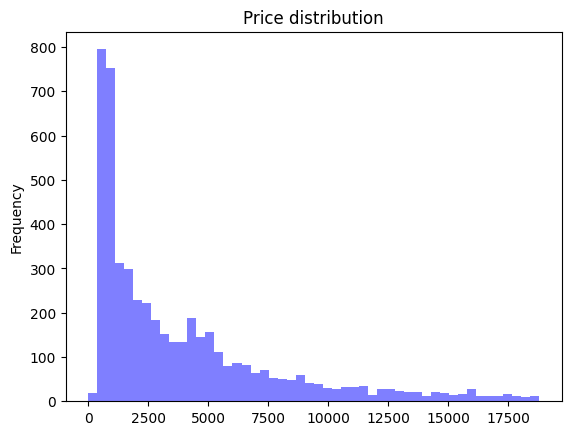

In [4]:
df.price.plot.hist(bins=50, alpha=0.5, color='b', title='Price distribution');

In [5]:
# DATA PREPROCESSING
X = df.drop(columns=["price"])
y = df[["price"]]

# COLUMNS CATEGORIZATION
numerical_features = X.select_dtypes(include='number').columns
categories_count = (X.loc[:, (X.dtypes == "object").values]
        .apply(lambda x: x.to_frame().drop_duplicates().value_counts(), axis=0)
        .sum())

binary_features = categories_count[categories_count == 2].index.to_list()
categorical_features = categories_count[categories_count > 2].index.to_list()

# SPLITTING DATA: Train | Validation | Test
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
        X, y,
        test_size=0.02,
        random_state=42,
        verbose=True
)

DATA SPLIT INFORMATION:        
Total rows: 5000 - columns: 9        
Training rows: 3920        
Validation rows: 980        
Testing rows: 100        


In [6]:
# FEATURE ENGINEERING
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(X_train[categorical_features]);

In [7]:
X_train = pd.concat(
    [
        X_train.drop(columns=categorical_features).reset_index(),
        build_features(one_hot_encoder, X_train, categorical_features)
    ], axis=1).set_index('index')

X_val = pd.concat(
    [
        X_val.drop(columns=categorical_features).reset_index(),
        build_features(one_hot_encoder, X_val, categorical_features)
    ], axis=1).set_index('index')

X_test = pd.concat(
    [
        X_test.drop(columns=categorical_features).reset_index(),
        build_features(one_hot_encoder, X_test, categorical_features)
    ], axis=1).set_index('index')

In [8]:
scaler = StandardScaler()
scaler.fit(X_train);

In [9]:
X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns.str.replace(
        r"[^\w\s]", "_", regex=True
    ).str.replace("__+", "_", regex=True),
)

X_val = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns.str.replace(
        r"[^\w\s]", "_", regex=True
    ).str.replace("__+", "_", regex=True),
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns.str.replace(
        r"[^\w\s]", "_", regex=True
    ).str.replace("__+", "_", regex=True),
)

In [10]:
X_train.head()

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-0.541960,-0.724446,-0.643558,-0.355890,-0.387085,-0.449039,-0.1754,-0.315073,-0.831332,1.699673,...,-0.336630,-0.226319,-0.11016,-0.176171,-0.554561,-0.454450,-0.445433,1.853210,-0.266530,-0.322358
1,0.490648,-2.691039,1.635140,0.921927,0.862522,0.522568,-0.1754,3.173869,-0.831332,-0.588348,...,-0.336630,-0.226319,-0.11016,-0.176171,-0.554561,2.200461,-0.445433,-0.539604,-0.266530,-0.322358
2,-0.821625,1.663559,-1.555037,-0.892037,-0.881534,-0.724569,-0.1754,-0.315073,-0.831332,-0.588348,...,-0.336630,-0.226319,-0.11016,-0.176171,1.803227,-0.454450,-0.445433,-0.539604,-0.266530,-0.322358
3,-0.950701,-0.162563,-0.187818,-1.070753,-1.052343,-1.072608,-0.1754,-0.315073,1.202889,-0.588348,...,-0.336630,-0.226319,-0.11016,-0.176171,-0.554561,-0.454450,-0.445433,-0.539604,3.751923,-0.322358
4,1.114516,0.258850,-0.643558,1.154257,1.186161,1.204143,-0.1754,-0.315073,1.202889,-0.588348,...,2.970616,-0.226319,-0.11016,-0.176171,-0.554561,-0.454450,2.245008,-0.539604,-0.266530,-0.322358


In [11]:
# MODELING: LightGBM | DNN | XGBoost
train_set = lgb.Dataset(X_train, label=y_train)
val_set = lgb.Dataset(X_val, label=y_val)

params = {
    "objective": "regression",
    "metric": "l1",
    "learning_rate": 0.01,
    "max_depth": 10,
    "num_leaves": 15,
    "min_child_samples": 9,
    "verbose": 2,
    "n_jobs": -1,
    "extra_trees":False,
    "random_state": 42,
}

lgbm = lgb.train(params, train_set, num_boost_round=3000, callbacks=[lgb.early_stopping(100)], valid_sets=[train_set, val_set])

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.863614
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.631103
[LightGBM] [Debug] init for col-wise cost 0.000736 seconds, init for row-wise cost 0.000474 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 26
[LightGBM] [Info] Start training from score 3910.685969
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tre

In [12]:
# MODEL PREDICTION
lgbm_pred_train = lgbm.predict(X_train)
lgbm_pred_val = lgbm.predict(X_val)
lgbm_pred_test = lgbm.predict(X_test)

In [13]:
# FEATURE IMPORTANCE RANKING
oka = dict(zip(lgbm.feature_importance(), X_test.columns))
sorted_oka = dict(sorted(oka.items(), key=lambda x: x[0], reverse=True))
sorted_oka

{2798: 'carat',
 1997: 'y',
 1958: 'z',
 1895: 'x',
 1434: 'depth',
 806: 'clarity_SI2',
 653: 'color_J',
 648: 'table',
 528: 'clarity_I1',
 517: 'color_D',
 502: 'clarity_SI1',
 475: 'color_I',
 414: 'color_E',
 395: 'clarity_VVS2',
 382: 'clarity_VVS1',
 373: 'color_H',
 351: 'clarity_IF',
 330: 'color_F',
 248: 'clarity_VS2',
 235: 'cut_Ideal',
 213: 'color_G',
 186: 'clarity_VS1',
 96: 'cut_Premium',
 32: 'cut_Good',
 27: 'cut_Fair',
 8: 'cut_Very_Good'}

(Total price of sample, Predicted total price, Difference)


(15329889, 15329889, 0)

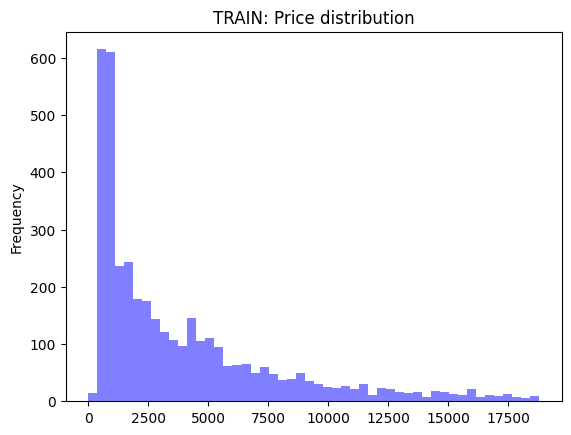

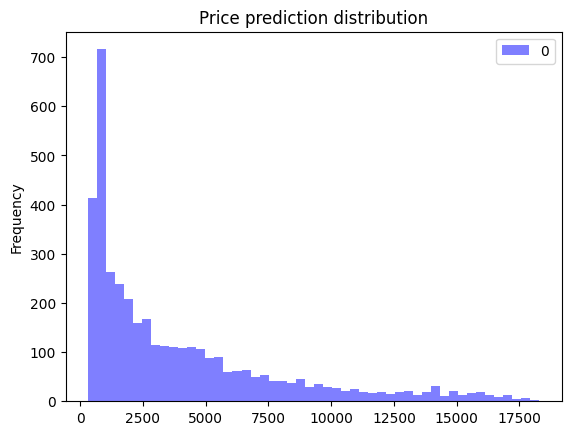

In [14]:
print("(Total price of sample, Predicted total price, Difference)")
y_train.price.plot.hist(bins=50, alpha=0.5, color='b', title='TRAIN: Price distribution'),
pd.DataFrame(lgbm_pred_train).plot.hist(bins=50, alpha=0.5, color='b', title='Price prediction distribution'),
(total := y_train.price.sum()), (pred_total := int(pd.DataFrame(lgbm_pred_train).sum().values[0])), (pred_total- total)

(Total price of sample, Predicted total price, Difference)


(3914589, 3907254, -7335)

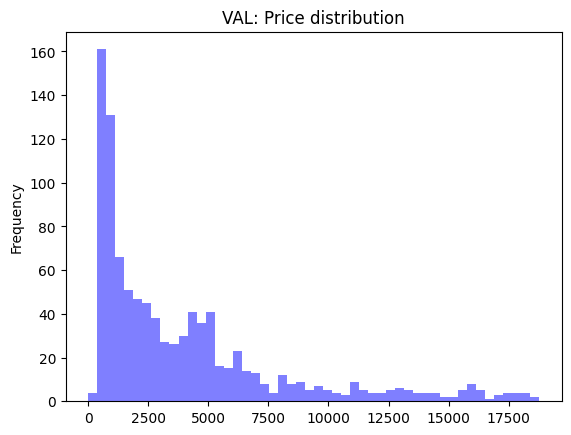

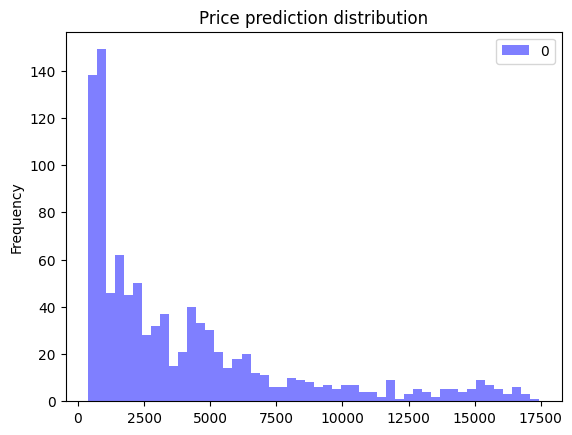

In [15]:
print("(Total price of sample, Predicted total price, Difference)")
y_val.price.plot.hist(bins=50, alpha=0.5, color='b', title='VAL: Price distribution'),
pd.DataFrame(lgbm_pred_val).plot.hist(bins=50, alpha=0.5, color='b', title='Price prediction distribution'),
(total := y_val.price.sum()), (pred_total := int(pd.DataFrame(lgbm_pred_val).sum().values[0])), (pred_total- total) 

(Total price of sample, Predicted total price, Difference)


(383219, 388577, 5358)

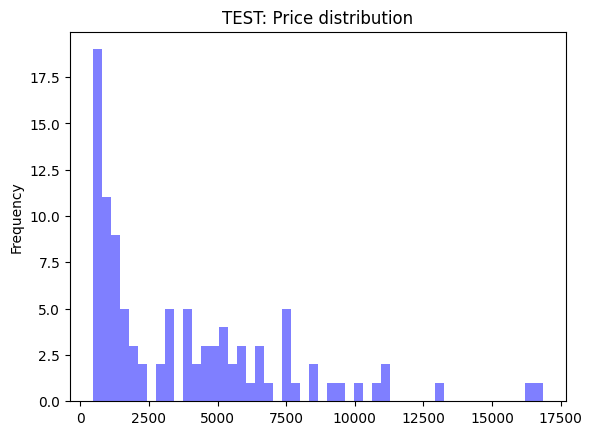

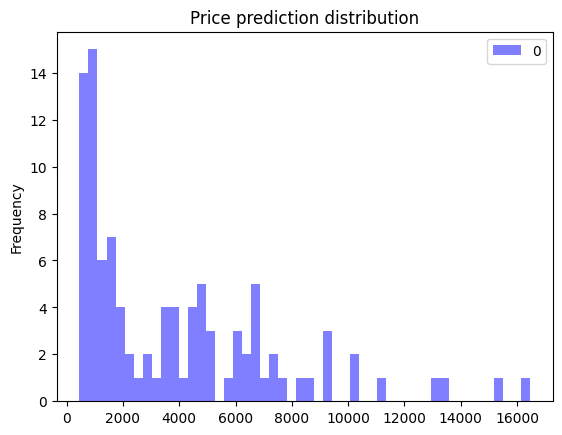

In [16]:
print("(Total price of sample, Predicted total price, Difference)")
y_test.price.plot.hist(bins=50, alpha=0.5, color='b', title='TEST: Price distribution'),
pd.DataFrame(lgbm_pred_test).plot.hist(bins=50, alpha=0.5, color='b', title='Price prediction distribution'),
(total := y_test.price.sum()), (pred_total := int(pd.DataFrame(lgbm_pred_test).sum().values[0])), (pred_total- total) 

In [17]:
# PREDICTION METRICS
lgbm_r2_train = r2_score(y_train.price, lgbm_pred_train)
lgbm_r2_val = r2_score(y_val.price, lgbm_pred_val)
lgbm_r2_test = r2_score(y_test.price, lgbm_pred_test)
r2_var_train = explained_variance_score(y_train.price, lgbm_pred_train)
r2_var_val = explained_variance_score(y_val.price, lgbm_pred_val)
r2_var_test = explained_variance_score(y_test.price, lgbm_pred_test)

lgbm_mae_train = mean_absolute_error(y_train.price, lgbm_pred_train)
lgbm_mae_val = mean_absolute_error(y_val.price, lgbm_pred_val)
lgbm_mae_test = mean_absolute_error(y_test.price, lgbm_pred_test)

lgm_max_train = max_error(y_train.price, lgbm_pred_train)
lgm_max_val = max_error(y_val.price, lgbm_pred_val)
lgm_max_test = max_error(y_test.price, lgbm_pred_test)

print("EXECUTION METRICS")
print(f"R2 Score Train: {lgbm_r2_train:.2f} with Variance score: {r2_var_train:.2f}")
print(f"R2 Score Validation: {lgbm_r2_val:.2f} with Variance score: {r2_var_train:.2f}")
print(f"R2 Score Test: {lgbm_r2_test:.2f} with Variance score: {r2_var_train:.2f}")
print()
print(f"MAE Score Train: {lgbm_mae_train:.2f}")
print(f"MAE Score Validation: {lgbm_mae_val:.2f}")
print(f"MAE Score Test: {lgbm_mae_test:.2f}")
print()
print(f"Max error in Train: {lgm_max_train:.2f}")
print(f"Max error in Validation: {lgm_max_val:.2f}")
print(f"Max error in Test: {lgm_max_test:.2f}")

EXECUTION METRICS
R2 Score Train: 0.99 with Variance score: 0.99
R2 Score Validation: 0.96 with Variance score: 0.99
R2 Score Test: 0.96 with Variance score: 0.99

MAE Score Train: 255.49
MAE Score Validation: 377.58
MAE Score Test: 323.34

Max error in Train: 8702.61
Max error in Validation: 10067.80
Max error in Test: 4297.61


# Challenge 2: Automated pipeline

# Challenge 3: Rest API

# Challenge 4: Architecture explanation

The next step is exposing the model to other businesses, but this calls for an upgrade in the training and serving infrastructure. Using your favorite cloud provider, either AWS, GCP, or Azure, design cloud-based training and serving pipelines. You should not implement the solution, but you should provide a detailed explanation of the architecture and the services you would use, motivating your choices.